In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

### Getting data information:

In [2]:
''' Get information about the dataset '''
words = open('names.txt', 'r').read().splitlines()

random.seed(42)
random.shuffle(words)

print('First 8 words in file:\n', words[:8])
print('\nTotal words in file: ', len(words))

First 8 words in file:
 ['yuheng', 'diondre', 'xavien', 'jori', 'juanluis', 'erandi', 'phia', 'samatha']

Total words in file:  32033


### Creating useful mappings:

In [3]:
''' Create mappings between characters and integers '''
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

print('\nMapping string to integer: ', stoi)
print('Mapping integer to string: ', itos)

vocab_size = len(stoi)

print(itos)
print(vocab_size)



Mapping string to integer:  {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
Mapping integer to string:  {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


### Building the dataset:

In [4]:
''' Building the dataset '''
# Takes in a list of names and an int which determines 
# how many previous chars are used for the prediction.
# Returns the inputs (X) and labels (Y) of the dataset
def build_dataset(words, block_size):
    X, Y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

### Creating the training and testing datasets:

In [5]:
''' Creating the train and test datasets '''
split1 = 0.8 # percentage of the words used to train the model
split2 = 0.9 # split1 - split2 = percentage of the words used to validate and test the model
words1 = round(split1 * len(words))
words2 = round(split2 * len(words))
block_size = 3 # amount of characters used for the prediction

x_train, y_train = build_dataset(words[:words1], block_size) # 80%
x_validate, y_validate = build_dataset(words[words1:words2], block_size) # 10%
x_test, y_test = build_dataset(words[words2:], block_size) # 10%

### Displaying some of the datasets

In [6]:
for x, y in zip(x_train[:20], y_train[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

... --> y
..y --> u
.yu --> h
yuh --> e
uhe --> n
hen --> g
eng --> .
... --> d
..d --> i
.di --> o
dio --> n
ion --> d
ond --> r
ndr --> e
dre --> .
... --> x
..x --> a
.xa --> v
xav --> i
avi --> e


## Creating the API:

In [20]:
''' Represents a linear layer '''
from typing import Any


class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / (fan_in**0.5)
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

''' Represents a batch normalization layer '''
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

''' Represents the hyperpoblic tangent function '''   
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
    
''' Represents the embedding of the characters '''
class Embedding:

    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]

''' A Layer which flattens its input '''
class Flatten:

    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []
    
''' A sequential class to wrap all layers together '''
class Sequential:

    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


## Initializing the model:

In [21]:
torch.manual_seed(42);

In [23]:
features = 10 # dimensionaly of the character feature vectors
neurons = 200 # neurons in the hidden layer

''' Creating the MLP '''
model = Sequential([
    Embedding(vocab_size, features),
    Flatten(),
    Linear(block_size * features, neurons, bias=False), BatchNorm1d(neurons), Tanh(),
    Linear(              neurons, vocab_size)
])

with torch.no_grad():
    layers[-1].weight *= 0.1 # initialize with a more uniform distribution

parameters = model.parameters()
print("Total parameters: ", sum(p.nelement() for p in parameters)) # print total parameters
for p in parameters:
    p.requires_grad = True

Total parameters:  12097


## Training the model:

In [24]:
epochs = 200000
batch_size = 32
lossi = []
ud = []

for i in range(1,epochs+1):

    ''' construct minibatch '''
    ix = torch.randint(0, x_train.shape[0], (batch_size,))
    x_batch, y_batch = x_train[ix], y_train[ix]

    ''' forward pass '''
    logits = model(x_batch)
    loss = F.cross_entropy(logits, y_batch) # loss function

    ''' backward pass '''
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < epochs * 0.66 else 0.01 # defining the learning rate
    for p in parameters:
        p.data -= lr * p.grad
    
    ''' tracking information '''
    if i == 1: print(i, "/", epochs, ": ", loss.item())
    if i % 10000 == 0: print(i, "/", epochs, ": ", loss.item())
    lossi.append(loss.item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

1 / 200000 :  3.516507625579834
10000 / 200000 :  2.0122392177581787
20000 / 200000 :  2.2419915199279785
30000 / 200000 :  2.252814769744873
40000 / 200000 :  2.122112989425659
50000 / 200000 :  2.4194161891937256
60000 / 200000 :  2.3430886268615723
70000 / 200000 :  2.4553608894348145
80000 / 200000 :  2.044236421585083
90000 / 200000 :  2.3989670276641846
100000 / 200000 :  2.339928388595581
110000 / 200000 :  2.4107024669647217
120000 / 200000 :  2.0361833572387695
130000 / 200000 :  2.034493923187256
140000 / 200000 :  2.247671127319336
150000 / 200000 :  1.9692447185516357
160000 / 200000 :  2.380185127258301
170000 / 200000 :  2.1350018978118896
180000 / 200000 :  1.9760613441467285
190000 / 200000 :  1.950618028640747
200000 / 200000 :  1.7893327474594116


## The model's loss:

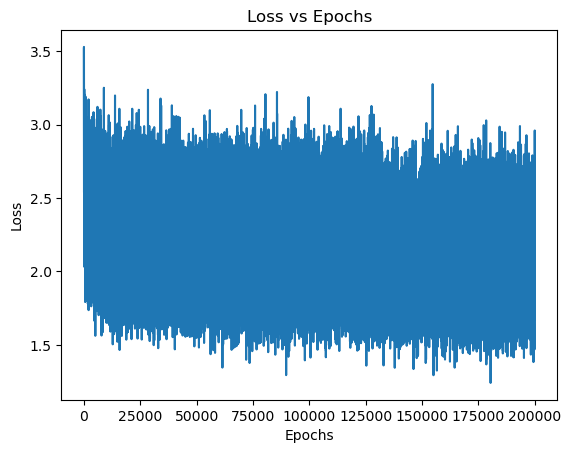

In [25]:
plt.plot(range(len(lossi)),lossi);
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss");

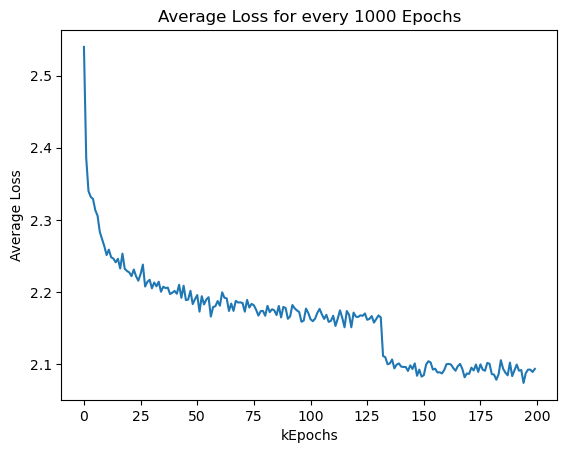

In [26]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1));
plt.title("Average Loss for every 1000 Epochs")
plt.ylabel("Average Loss")
plt.xlabel("kEpochs");

### Expected loss:

In [27]:
print('Expected loss:', -torch.tensor(1/27.0).log())

Expected loss: tensor(3.2958)


### Loss on training set:

In [28]:
print('Training set loss:', lossi[-1])

Training set loss: 1.7893327474594116


### Loss on all sets:

In [29]:
''' Tell batchnorm layers we're done training '''
for layer in model.layers:
    layer.training = False

In [38]:
''' Get final loss on training set '''
logits = model(x_train)
loss = F.cross_entropy(logits, y_train) # loss function
print("Treaining set loss:", loss.item())


''' Get final loss on validation set '''
logits = model(x_validate)
loss = F.cross_entropy(logits, y_validate) # loss function
print("Validation set loss:", loss.item())


''' Get final loss on training set '''
logits = model(x_test)
loss = F.cross_entropy(logits, y_test) # loss function
print("Test set loss:", loss.item())

Treaining set loss: 2.060030460357666
Validation set loss: 2.1079721450805664
Test set loss: 2.108586549758911


## Model predictions:

In [40]:
with torch.no_grad():
    for _ in range(20): # sample 20 words

        out = []
        context = [0] * block_size # inputs
        while True:

            logits = model(torch.tensor([context]))
            probs = F.softmax(logits, dim=1)
            # Sample from probability distribution
            ix = torch.multinomial(probs, num_samples=1).item()

            context = context[1:] + [ix]
            out.append(ix)

            if ix == 0:
                break

        print(''.join(itos[i] for i in out))

zaina.
laniclonavie.
jose.
mcen.
clae.
julishe.
jah.
jah.
tavee.
aizermaresir.
ron.
jal.
jer.
lein.
maja.
jaymontaan.
ubiakean.
aarvin.
cray.
grayah.
